In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import vb4kde as kde

Load some data...

In [2]:
from torchvision.datasets import MNIST
testset = MNIST('mnist', train=False, download=True)

mnist_pca = torch.load('mnist_pca.pt')
X_reduced = mnist_pca['X_reduced'].float()
X_test = X_reduced[60000:]

Let's take a look at the model for the digit 8

In [3]:
target = 8

In [4]:
model = kde.load_kde('models/kde_vb_' + str(target) +'.pt')
model.nu * model.W

tensor([[ 43.4331,   1.2231,   0.6333,  ...,  -0.6988,  -0.8338,  -0.7400],
        [  1.2231,  66.4666,  -3.7694,  ...,   5.6959, -15.6400,  -0.1515],
        [  0.6333,  -3.7693,  45.5689,  ...,  -0.7915,   3.0311,   6.8274],
        ...,
        [ -0.6988,   5.6959,  -0.7914,  ...,  16.3363,  -9.9079,  -5.4348],
        [ -0.8338, -15.6399,   3.0311,  ...,  -9.9080,  56.0486,  26.2559],
        [ -0.7400,  -0.1515,   6.8274,  ...,  -5.4348,  26.2559,  34.2009]])

In [5]:
(testset.targets == target).sum()

tensor(974)

In [6]:
def plot_digits(data, num_rows):
    plt.figure(figsize=(2 * len(data) / num_rows, 2 * num_rows))
    plt.tight_layout()
    
    for i, d in enumerate(data):
        
        plt.subplot(num_rows, len(data) / num_rows, i+1)
        plt.imshow(d, cmap='gray', interpolation='none')
        plt.xticks([])
        plt.yticks([])
    
    plt.show()

Let's compare the top 10 highest density observations in the test set with the 10 lowest density ones

In [7]:
X_reduced_target = X_reduced[60000:][testset.targets == target]
X_target = testset.data[testset.targets == target]

log_dens = model.log_density(X_reduced_target)
sorted_dens, sorted_idx = torch.sort(log_dens, descending=False)

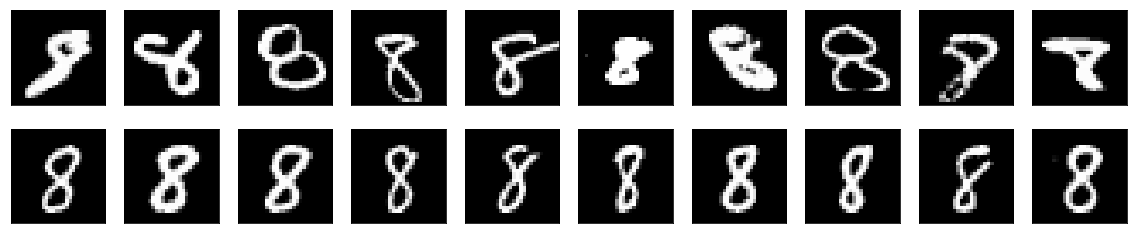

In [8]:
plot_digits(torch.cat((X_target[sorted_idx[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]], 
                       X_target[sorted_idx[[-1, -2, -3, -4, -5, -6, -7, -8, -9, -10]]])), 2)

We can build a classifier by predicting an observation as belonging to the KDE it has the highest density under

In [9]:
class KDEClassifier:
    def __init__(self, models):
        self.models = models
        
    def predict(self, X):
        
        pred = torch.stack(tuple(model.log_density(X) for model in self.models), dim=0)
        return pred.argmax(dim=0)

In [10]:
models = [kde.load_kde('models/kde_vb_' + str(i) +'.pt') for i in range(10)]
classifier = KDEClassifier(models)

In [ ]:
pred = classifier.predict(X_test)

In [ ]:
(pred == testset.targets).sum().item() / len(testset)

This simple model gives a 90% accuracy on MNIST :O

In [11]:
from sklearn.neighbors import KernelDensity

In [12]:
bandwidths = [0.33, 0.2, 0.73, 0.43, 0.36, 0.41, 0.47, 0.46, 0.36, 0.37]
sklearn_models = [KernelDensity(kernel='gaussian', bandwidth=bw) for bw in bandwidths]

for m, sk_m in zip(models, sklearn_models):
    sk_m.fit(m.X.numpy())

In [18]:
class KDEClassifier:
    def __init__(self, models):
        self.models = models
        
    def predict(self, X):
        
        pred = np.stack(tuple(model.score_samples(X) for model in self.models), axis=0)
        return pred.argmax(axis=0)

In [19]:
classifier = KDEClassifier(sklearn_models)

In [20]:
pred = classifier.predict(X_test.numpy())

In [21]:
(pred == testset.targets.numpy()).sum() / len(testset)

0.2968